# Performance comparison in the presence of unreported contacts

This notebook reproduces Fig. 5. 

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', font_scale=1)

Set the values of sensitivity s<sub>e</sub> and specificity s<sub>p</sub>.

In [3]:
se=0.8
sp=0.98

In [4]:
name="hidden_contacts"
width_pt = 469
palette = sns.color_palette('husl', 6)
type_dict = {
    'N' : int,
    'untraced' : float, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'bench' : bool,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'd' : float,
    'seed' : int
}

In [5]:
files = glob.glob("./outputs/{name}_*_se_{se}_sp_{sp}_*.json".format(name=name, se=se, sp=sp))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        avg_group_size = np.mean(sizes)
        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['avg_group_size'] = avg_group_size

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 64/64


In [6]:
total_df = input_df.astype(type_dict) # Fix types
total_df = total_df.rename(columns={'avg_group_size' : 'Average pool size'})

In [7]:
perc_df=total_df.pivot(index=['lambda_1', 'lambda_2', 'se', 'sp', 'r', 'k', 'd', 'bench', 'seed', 'N', 'untraced'], columns='method', values='score').reset_index()
perc_df=perc_df[perc_df['bench']==False]
perc_df['Percentage'] = (perc_df['binomial'] - perc_df['negbin'])/perc_df['binomial']*100
perc_df = perc_df[['N', 'untraced', 'Percentage']]
perc_df['traced'] = (1-perc_df['untraced'])*100

In [8]:
infected_df=total_df[['lambda_1', 'lambda_2', 'se', 'sp', 'r', 'k', 'd', 'method', 'seed', 'N', 'untraced', 'bench', 'num_of_infected']]
infected_df=infected_df[infected_df['bench']==False]
infected_df = infected_df.rename(columns={'num_of_infected': 'Num of infected'})
infected_df['traced'] = (1-infected_df['untraced'])*100

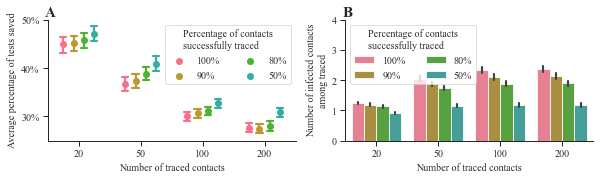

In [11]:
utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2*fig_height*fig_aspect,fig_height))

# Subplot 1
traced = sorted(perc_df['traced'].unique(), reverse=True)
sns.pointplot(data=perc_df, x="N", y="Percentage", hue="traced", palette=palette[0:4],
            ci=95, join=False, dodge=.5, capsize=0.1, legend=False, hue_order=traced, ax=ax1)
sns.despine()

handles, labels = ax1.get_legend_handles_labels()
labels = [x[:-2]+r'%' for x in labels]
ax1.legend(handles=handles, labels=labels, title='Percentage of contacts\nsuccessfully traced', ncol=2, loc='upper right')#, bbox_to_anchor=(0.45, 1))
ax1.set_ylabel('Average percentage of tests saved')
ax1.set_xlabel('Number of traced contacts')
ax1.set_ylim([25,50])
ax1.set_yticks([30, 40, 50])
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))

ax1.text(x=0.01, y=1, s=r'A', size=15, transform = ax1.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')

# Subplot 2
traced = sorted(infected_df['traced'].unique(), reverse=True)
sns.barplot(data=infected_df, x="N", y="Num of infected", hue="traced", palette=palette[0:4],
            ci=95, hue_order=traced, ax=ax2)
sns.despine()

handles, labels = ax2.get_legend_handles_labels()
labels = [x[:-2]+r'%' for x in labels]
ax2.legend(handles=handles, labels=labels, title='Percentage of contacts\nsuccessfully traced', ncol=2, loc='upper left')#, bbox_to_anchor=(0.45, 1))
ax2.set_ylabel('Number of infected contacts\namong traced')
ax2.set_xlabel('Number of traced contacts')
ax2.set_ylim([0,4])

ax2.text(x=0.01, y=1, s=r'B', size=15, transform = ax2.transAxes, horizontalalignment='center', verticalalignment='bottom', weight='bold')

fig.tight_layout()
fig.savefig('figures/fig5.tif', dpi=300)